In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

#import poppy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # change this per computer
import psd_functions as psd
import datafiles as dfx

#import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 5,
             'diam_ca100': 50*u.mm,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm} # useful for PSD

oap = psd.surfPSD(surf_name='avg_oap')
oap.open_psd(psd_fileloc='zygo_data/oaps/oap_coated/oap_avgPSD_centered_80CA.fits', psd_type='cal')
oap.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'], pwr_opt=oap.psd_cal)
oap.calc_psd_radial(ring_width=opt_parms['ring_width'])

In [3]:
clf = psd.surfPSD(surf_name='coastline_flat')
clf.open_psd(psd_fileloc='zygo_data/flat_mirrors/coastline_test/coastline_80CA_PSD_masked.fits', psd_type='cal')
clf.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'], pwr_opt=clf.psd_cal)
clf.calc_psd_radial(ring_width=opt_parms['ring_width'])

In [4]:
fm2in = psd.surfPSD(surf_name='fm_2inch_avg')
fm2in.open_psd(psd_fileloc='zygo_data/flat_mirrors/fixed_fits/flat_2in_ca{0}_avg_dustmask_PSD.fits'.format(opt_parms['ca']),
               psd_type='cal')
fm2in.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'], pwr_opt=fm2in.psd_cal)
fm2in.calc_psd_radial(ring_width=opt_parms['ring_width'])

In [5]:
fm1in = psd.surfPSD(surf_name='fm_1inch_avg')
fm1in.open_psd(psd_fileloc='zygo_data/flat_mirrors/fixed_fits/flat_1in_ca{0}_avg_dustmask_PSD.fits'.format(opt_parms['ca']),
               psd_type='cal')
fm1in.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'], pwr_opt=fm2in.psd_cal)
fm1in.calc_psd_radial(ring_width=opt_parms['ring_width'])

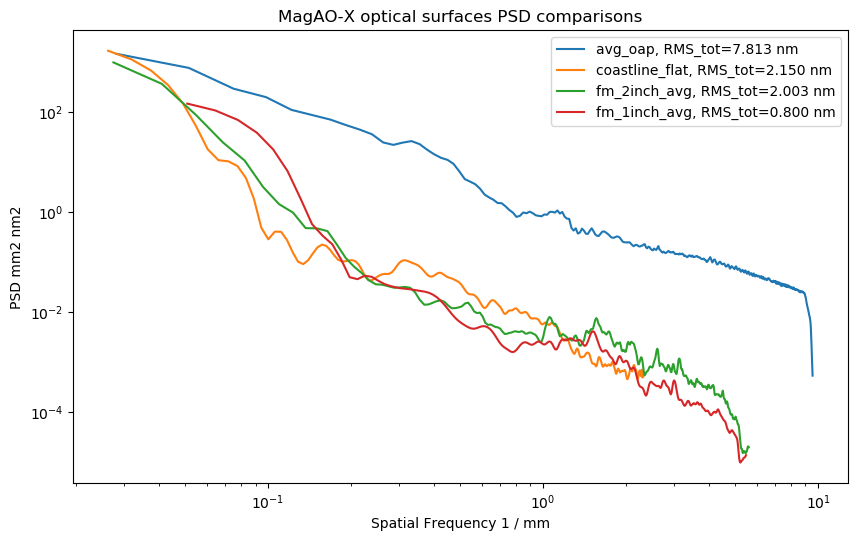

In [6]:
# print plot
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(oap.k_radial.value, oap.psd_radial_cal.value, label='{0}, RMS_tot={1:.3f}'.format(oap.surf_name, oap.rms_tot))
plt.loglog(clf.k_radial.value, clf.psd_radial_cal.value, label='{0}, RMS_tot={1:.3f}'.format(clf.surf_name, clf.rms_tot))
plt.loglog(fm2in.k_radial.value, fm2in.psd_radial_cal.value, label='{0}, RMS_tot={1:.3f}'.format(fm2in.surf_name, fm2in.rms_tot))
plt.loglog(fm1in.k_radial.value, fm1in.psd_radial_cal.value, label='{0}, RMS_tot={1:.3f}'.format(fm1in.surf_name, fm1in.rms_tot))
plt.xlabel('Spatial Frequency {0}'.format(clf.k_radial.unit))
plt.ylabel('PSD {0}'.format(clf.psd_radial_cal.unit))
plt.title('MagAO-X optical surfaces PSD comparisons')
plt.legend()

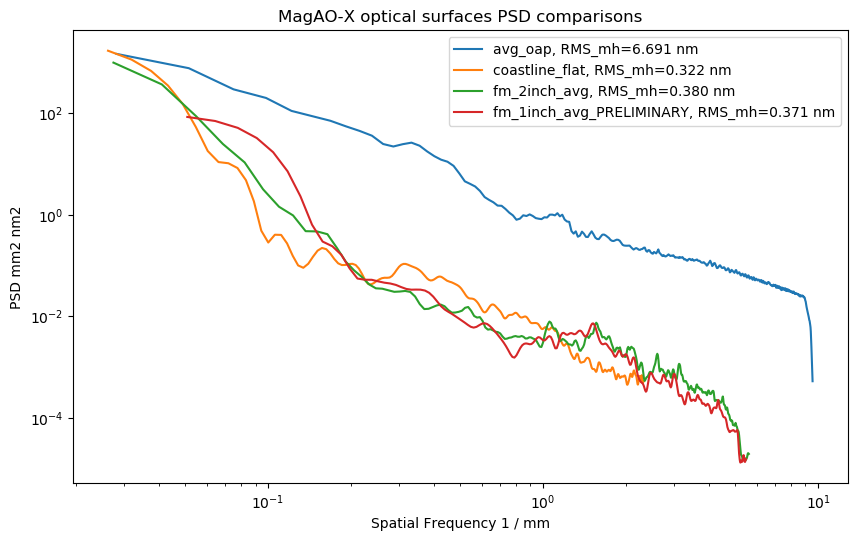

In [11]:
# print plot
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(oap.k_radial.value, oap.psd_radial_cal.value, label='{0}, RMS_mh={1:.3f}'.format(oap.surf_name, oap.rms_mh))
plt.loglog(clf.k_radial.value, clf.psd_radial_cal.value, label='{0}, RMS_mh={1:.3f}'.format(clf.surf_name, clf.rms_mh))
plt.loglog(fm2in.k_radial.value, fm2in.psd_radial_cal.value, label='{0}, RMS_mh={1:.3f}'.format(fm2in.surf_name, fm2in.rms_mh))
plt.loglog(fm1in.k_radial.value, fm1in.psd_radial_cal.value, label='{0}, RMS_mh={1:.3f}'.format(fm1in.surf_name, fm1in.rms_mh))
plt.xlabel('Spatial Frequency {0}'.format(clf.k_radial.unit))
plt.ylabel('PSD {0}'.format(clf.psd_radial_cal.unit))
plt.title('MagAO-X optical surfaces PSD comparisons')
plt.legend()

In [42]:
# surface comparison
oap_surf = fits.open('zygo_data/oaps/oap_coated/oap5_sn2_centered_80CA_surf.fits')[0].data*u.micron
oap_mask = fits.open('zygo_data/oaps/oap_coated/oap5_sn2_centered_80CA_mask.fits')[0].data
oap_data = dfx.sn_map(oap_surf, oap_mask)

fm_surf = fits.open('zygo_data/flat_mirrors/fixed_fits/flat_2in_ca80_n8_median_surf.fits')[0].data*u.micron
fm_mask = fits.open('zygo_data/flat_mirrors/fixed_fits/flat_2in_ca80_n8_median_mask.fits')[0].data
fm_data = dfx.sn_map(fm_surf, fm_mask)

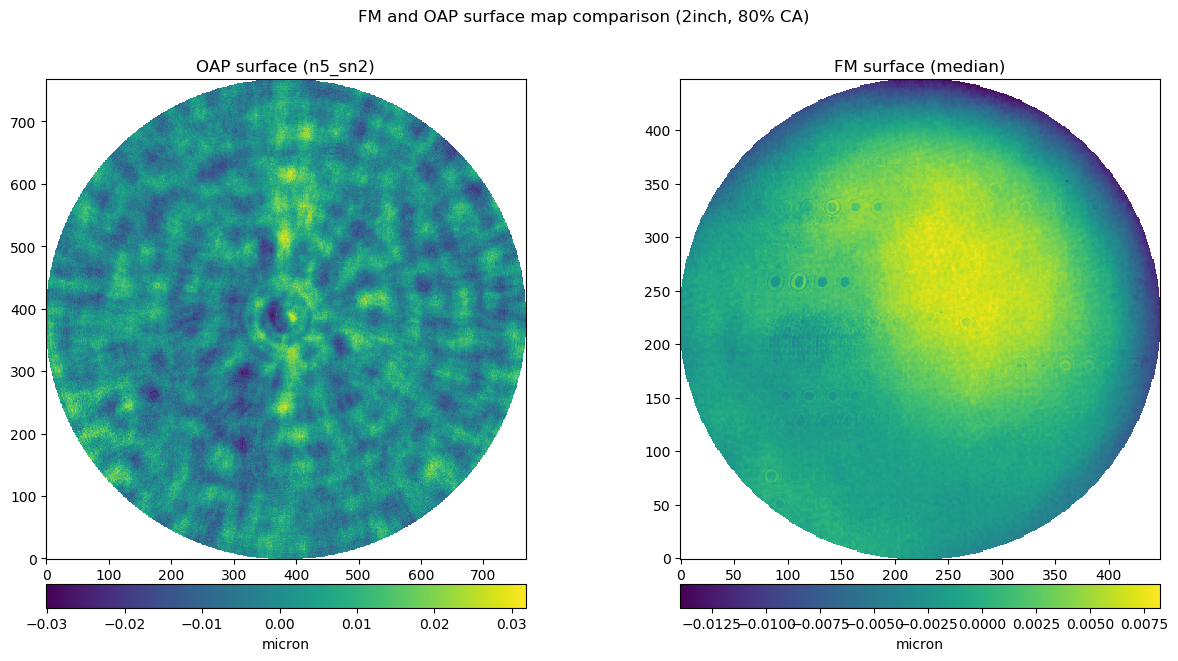

In [44]:
dfx.show2plots(supertitle='FM and OAP surface map comparison (2inch, 80% CA)',
               data1 = oap_data,
               plot1_label='OAP surface (n5_sn2)',
               data2 = fm_data,
               plot2_label='FM surface (median)',
               set_figsize=[15,7],
               set_dpi=100)